# Predictors of points (past 2 seasons: 2022 - 2024 data)

### Predictors considered

**Player Metrics**
* Influence (lag)
* Creativity (lag)
* Threat (lag)
* recent form 

**Team strengths**
* Home team str
* Away team str
* home advantage

**Crowd knowledge**
* Selected
* Change in transfers

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [74]:
pastSeasonsGW = pd.read_csv('../PastSeasonsData/Cleaned2022-2024GWData.csv', index_col=0)

In [75]:
print(pastSeasonsGW.columns)

Index(['name_x', 'position', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW', 'seasonEnd',
       'strength_x', 'team_strength_home', 'team_strength_away',
       'team_attack_home', 'team_attack_away', 'team_defence_home',
       'team_defence_away', 'name_y', 'id_x', 'strength_y',
       'opponent_strength_home', 'opponent_strength_away',
       'opponent_attack_home', 'opponent_attack_away', 'opponent_defence_home',
       'opponent_defence_a

In [76]:
str_cols = [col for col in pastSeasonsGW.columns if 'team_' in col or 'opponent_' in col]
ict_cols = ['influence', 'creativity', 'threat']
cols_of_interest = ['name_x', 'position', 'element', 'bonus', 'saves', 'selected', 'transfers_in', 'transfers_out', 
                    'clean_sheets', 'total_points', 'was_home'] + str_cols + ict_cols
print(cols_of_interest)
print(len(cols_of_interest))

['name_x', 'position', 'element', 'bonus', 'saves', 'selected', 'transfers_in', 'transfers_out', 'clean_sheets', 'total_points', 'was_home', 'opponent_team', 'team_a_score', 'team_h_score', 'team_strength_home', 'team_strength_away', 'team_attack_home', 'team_attack_away', 'team_defence_home', 'team_defence_away', 'opponent_strength_home', 'opponent_strength_away', 'opponent_attack_home', 'opponent_attack_away', 'opponent_defence_home', 'opponent_defence_away', 'influence', 'creativity', 'threat']
29


### Cleaning: remove players with little points?

In [ ]:
## Check: number of players
pastSeasonsGW.name_x.nunique()

## Remove players with no minutes
season23 = pd.read_csv('../PastSeasonsData/202223_cleaned_players.csv')
season24 = pd.read_csv('../PastSeasonsData/202324_cleaned_players.csv')



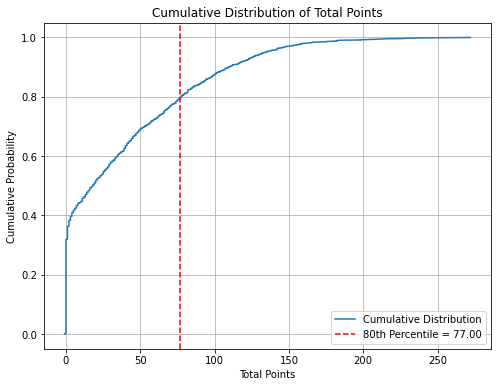

In [113]:
combined_seasons_totals = pd.concat([season23, season24])
sorted_points = np.sort(combined_seasons_totals.total_points)
cumulative = np.arange(1, len(sorted_points) + 1) / len(sorted_points)

# Calculate the 75th percentile
percentile_80 = np.percentile(sorted_points, 80)

# Plot the cumulative distribution
plt.figure(figsize=(8, 6))
plt.plot(sorted_points, cumulative, label='Cumulative Distribution')
plt.axvline(percentile_80, color='red', linestyle='--', label=f'80th Percentile = {percentile_80:.2f}')
plt.title('Cumulative Distribution of Total Points')
plt.xlabel('Total Points')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid()
plt.show()

In [114]:
min_points = 75

players_remove_23 = season23[season23['total_points'] < min_points][['first_name', 'second_name']].apply(lambda row: ' '.join(row), axis=1)
players_remove_24 =season24[season24['total_points'] < min_points][['first_name', 'second_name']].apply(lambda row: ' '.join(row), axis=1)

In [115]:
## remove players 
pastSeasonsGW_sig_players = pastSeasonsGW[
    ~( ##remove according to the following conditions
        ((pastSeasonsGW['seasonEnd'] == 2023) & (pastSeasonsGW.name_x).isin(players_remove_23)) |
        ((pastSeasonsGW['seasonEnd'] == 2024) & (pastSeasonsGW.name_x).isin(players_remove_24))
    )
]

In [116]:
print(pastSeasonsGW.name_x.nunique())
print(pastSeasonsGW_sig_players.name_x.nunique())

869
565


In [117]:
## Move on with the smaller subset
pastSeasonsGW_subset = pastSeasonsGW_sig_players

### Continue

### Feature engineering

In [118]:
pastSeasonsGW_subset.head()

## Feature engineering 
pastSeasonsGW_subset['transfers_change'] = pd.to_numeric(pastSeasonsGW_subset['transfers_in']) - pd.to_numeric(pastSeasonsGW_subset['transfers_out'])
## Team stregnth differentials (basic)
pastSeasonsGW_subset['team_str'] = pastSeasonsGW_subset.was_home*pastSeasonsGW_subset.team_strength_home + (1-pastSeasonsGW_subset.was_home)* pastSeasonsGW_subset.team_strength_away  
pastSeasonsGW_subset['opp_str'] = pastSeasonsGW_subset.was_home*pastSeasonsGW_subset.opponent_strength_away + (1-pastSeasonsGW_subset.was_home)* pastSeasonsGW_subset.opponent_strength_home  
# Finally, calculate difference in team strs
pastSeasonsGW_subset['teamsStrDiff'] =   pastSeasonsGW_subset.team_str - pastSeasonsGW_subset.opp_str

## Adding lagged variables 
for col in ['influence', 'creativity', 'threat']:
    pastSeasonsGW_subset[f'lag_{col}'] = pastSeasonsGW_subset[col].shift(1)
    pastSeasonsGW_subset.drop(columns=col, inplace=True)


/tmp/ipykernel_1020392/2271867487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSeasonsGW_subset['transfers_change'] = pd.to_numeric(pastSeasonsGW_subset['transfers_in']) - pd.to_numeric(pastSeasonsGW_subset['transfers_out'])
/tmp/ipykernel_1020392/2271867487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSeasonsGW_subset['team_str'] = pastSeasonsGW_subset.was_home*pastSeasonsGW_subset.team_strength_home + (1-pastSeasonsGW_subset.was_home)* pastSeasonsGW_subset.team_strength_away
/tmp/ipy

# ICT factors

### Player attributes

In [119]:
import numpy as np
import seaborn as sns

In [120]:
def heatmap_ict(position):

    data = pastSeasonsGW_subset[pastSeasonsGW_subset.position == position]
    attrs = ['lag_' + col for col in ict_cols] + ['total_points']
    cor = data[attrs].corr()
    trimask = np.triu(np.ones_like(cor, dtype=bool))
    sns.heatmap(cor, annot=True,cmap="YlGnBu", mask=trimask)
    plt.tight_layout()
    plt.show()

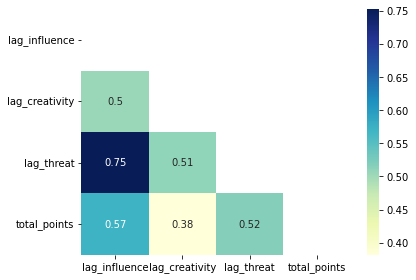

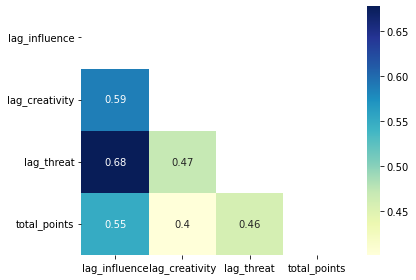

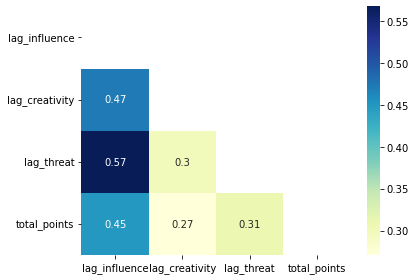

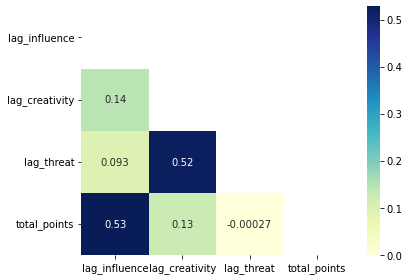

In [121]:
for position in ['FWD', 'MID', 'DEF', 'GK']:
    heatmap_ict(position)

 ## Team strengths 

In [122]:
pastSeasonsGW_subset.columns

Index(['name_x', 'position', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'element', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'kickoff_time',
       'minutes', 'opponent_team', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'starts',
       'team_a_score', 'team_h_score', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW', 'seasonEnd', 'strength_x', 'team_strength_home',
       'team_strength_away', 'team_attack_home', 'team_attack_away',
       'team_defence_home', 'team_defence_away', 'name_y', 'id_x',
       'strength_y', 'opponent_strength_home', 'opponent_strength_away',
       'opponent_attack_home', 'opponent_attack_away', 'opponent_defence_home',
       'opponent_defence_away', 'id_y', 'creativity_rolling_avg_2',
  

In [123]:
team_str_cols = ['was_home', 'team_str', 'opp_str', 'teamsStrDiff']
pastSeasonsGW_subset[team_str_cols + ['position']]

,was_home,team_str,opp_str,teamsStrDiff,position
29953,True,1170.0,1275,-105.0,FWD
30591,False,1175.0,1080,95.0,FWD
31212,True,1170.0,1130,40.0,FWD
31903,True,1170.0,1260,-90.0,FWD
32609,False,1175.0,1155,20.0,FWD
...,...,...,...,...,...
56584,True,1165.0,1220,-55.0,GK
57443,True,1165.0,1130,35.0,GK
58572,False,1220.0,1050,170.0,GK
58573,False,1220.0,1170,50.0,GK


In [124]:
def heatmap_team_strs(position):
    data = pastSeasonsGW_subset[pastSeasonsGW_subset.position == position]
    cor = data[team_str_cols + ['total_points']].corr()
    trimask = np.triu(np.ones_like(cor, dtype=bool))
    sns.heatmap(cor, annot=True,cmap="YlGnBu", mask=trimask)
    plt.title(f'Position: {position}')
    plt.tight_layout()
    plt.show()

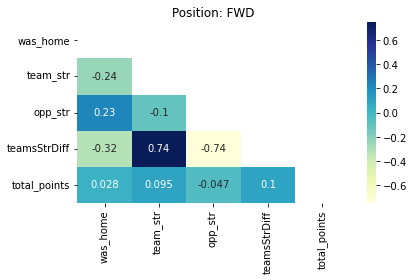

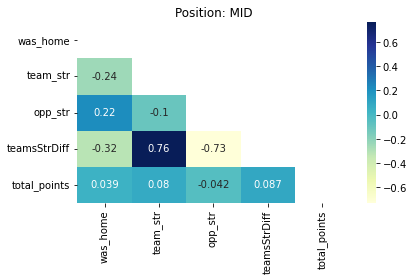

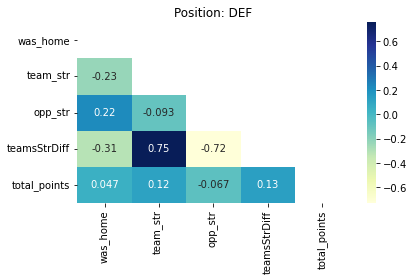

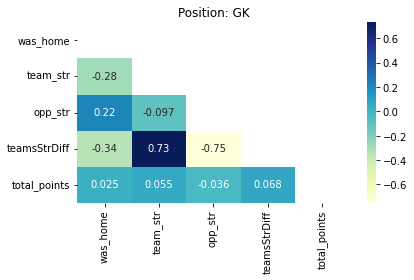

In [125]:
for position in ['FWD', 'MID', 'DEF', 'GK']:
    heatmap_team_strs(position)

# Crowd knowledge

In [126]:
pastSeasonsGW_subset.columns

Index(['name_x', 'position', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'element', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'kickoff_time',
       'minutes', 'opponent_team', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'starts',
       'team_a_score', 'team_h_score', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW', 'seasonEnd', 'strength_x', 'team_strength_home',
       'team_strength_away', 'team_attack_home', 'team_attack_away',
       'team_defence_home', 'team_defence_away', 'name_y', 'id_x',
       'strength_y', 'opponent_strength_home', 'opponent_strength_away',
       'opponent_attack_home', 'opponent_attack_away', 'opponent_defence_home',
       'opponent_defence_away', 'id_y', 'creativity_rolling_avg_2',
  

In [127]:
crowd_wisdom_factors = ['transfers_change', 'selected']
def heatmap_crowd_wisdom(position):
    data = pastSeasonsGW_subset[pastSeasonsGW_subset.position == position]
    cor = data[crowd_wisdom_factors + ['total_points']].corr()
    trimask = np.triu(np.ones_like(cor, dtype=bool))
    sns.heatmap(cor, annot=True,cmap="YlGnBu", mask=trimask)
    plt.title(f'Position: {position}')
    plt.tight_layout()
    plt.show()

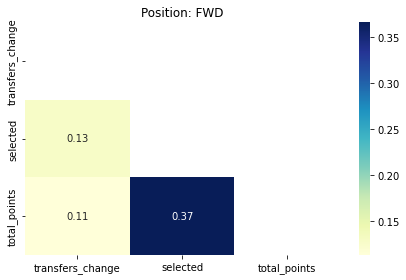

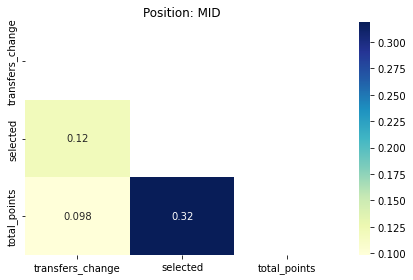

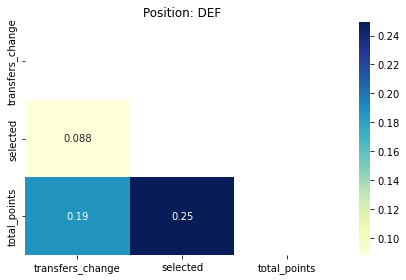

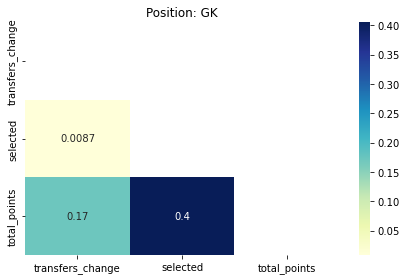

In [128]:
for position in ['FWD', 'MID', 'DEF', 'GK']:
    heatmap_crowd_wisdom(position)

# Regression

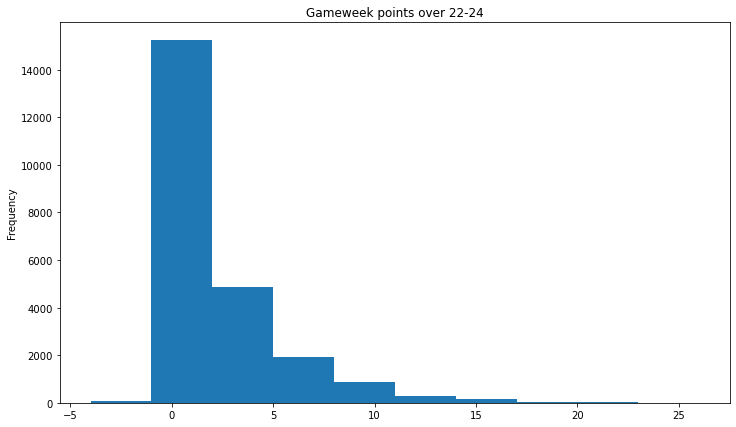

In [134]:
plt.figure(figsize=(12,7))
pastSeasonsGW_subset.total_points.plot(kind = 'hist')
plt.title('Gameweek points over 22-24')
plt.show()

In [131]:
## Remove negative points? 
pastSeasonsGW_subset_no_neg = pastSeasonsGW_subset[pastSeasonsGW_subset.total_points <0]

## Zero inflated Poisson model

In [135]:
import statsmodels.api as sum
from statsmodels.discrete.count_model import ZeroInflatedPoisson

In [137]:
## Gather predictors
lagged_ict_cols = ['lag_' + col for col in ict_cols]
features = ['transfers_change', 'selected', 'was_home', 'teamsStrDiff'] + lagged_ict_cols + ['clean_sheets']
pastSeasonsGW_subset_no_neg = pastSeasonsGW_subset_no_neg[['position', 'goals_scored'] + features].dropna()
